In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
import sys
from pathlib import Path
from time import time
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs, low_shelf, high_shelf

## Initialization Algorithm for Peaking Filters
**NOTE** this is a beta version, the final version is implemented in `PEQ`

In [3]:
def bandwidth(q):
    return np.log2(1 + 1 / (2 * self.q**2) + np.sqrt(((2 * q**2 + 1) / q**2)**2 / 4 - 1))

In [117]:
def biggest_peaks(fr):
    peak_ixs, peak_props = find_peaks(np.clip(fr, 0, None), width=0, prominence=0, height=0)
    dip_ixs, dip_props = find_peaks(np.clip(-fr, 0, None), width=0, prominence=0, height=0)
    
    ixs = np.concatenate([peak_ixs, dip_ixs])
    widths = np.concatenate([peak_props['widths'], dip_props['widths']])
    heights = np.concatenate([peak_props['peak_heights'], dip_props['peak_heights']])
    prominences = np.concatenate([peak_props['prominences'], dip_props['prominences']])
    sizes = widths * heights

    ix_sort = np.argsort(sizes)[::-1]
    ixs = ixs[ix_sort]
    widths = widths[ix_sort]
    heights = heights[ix_sort]
    prominences = prominences[ix_sort]
    
    return ixs, widths, heights, prominences

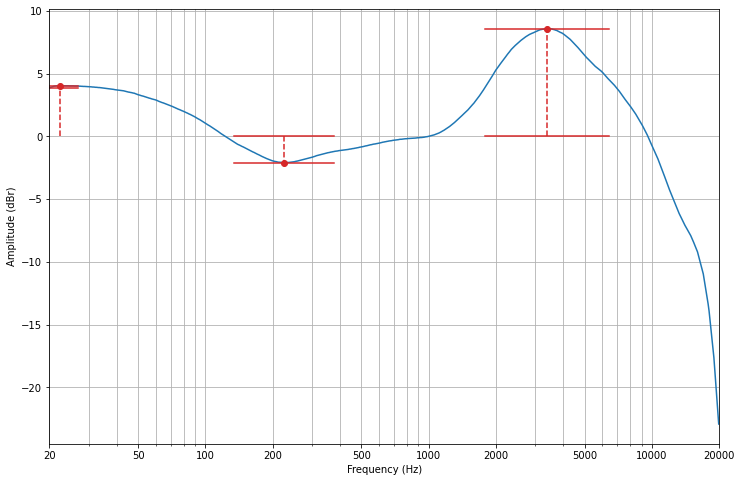

In [118]:
#f = FrequencyResponse.generate_frequencies()
#f_step = f_step = np.log(f[1] / f[0]) / np.log(2)
#fr = digital_coeffs(f, 44100, *peaking([100, 500, 1000, 2000, 6000], [1.4, 1.4, 4, 1.4, 1.4], [-1, 1, 0.3, 1.5, -1], fs=44100), reduce=True)
fr = FrequencyResponse.read_from_csv('../../compensation/harman_over-ear_2018.csv').raw

ixs, widths, heights, prominences = biggest_peaks(fr)

fig, ax = FrequencyResponse.init_plot()
ax.plot(f, fr)
ax.plot(f[ixs], fr[ixs], 'o', color='C3')
for ix, width, height, prominence in zip(ixs, widths, heights, prominences):
    x = [f[max(ix - int(np.round(width / 2)), 0)], f[min(ix + int(np.round(width / 2)), len(f) - 1)]]
    ax.plot(x, [fr[ix], fr[ix]], color='C3')
    height = height if fr[ix] > 0 else -height
    prominence = prominence if fr[ix] > 0 else -prominence
    ax.plot([f[ix], f[ix]], [fr[ix] - height, fr[ix]], '--', color='C3')
    ax.plot(x, [fr[ix] - prominence, fr[ix] - prominence], color='C3')
plt.show()

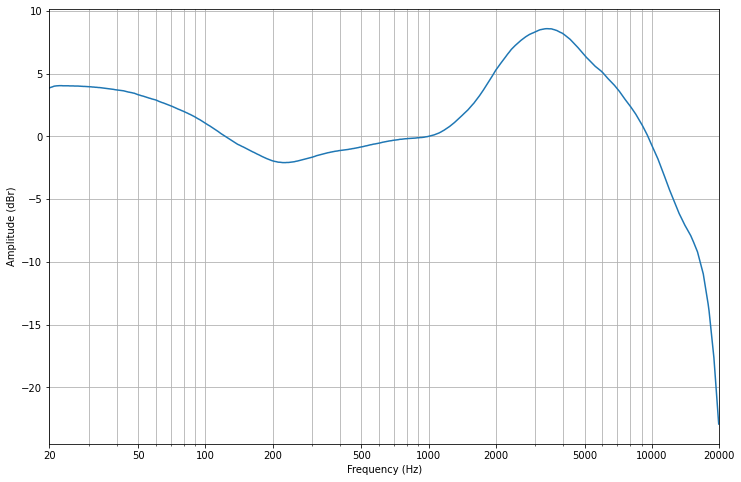

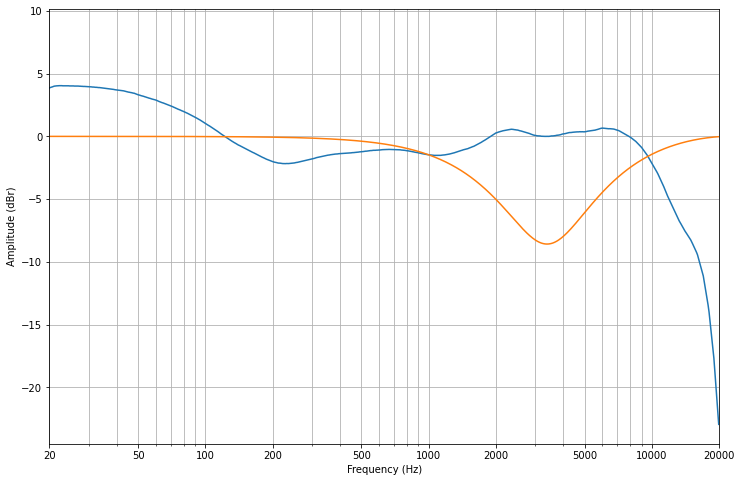

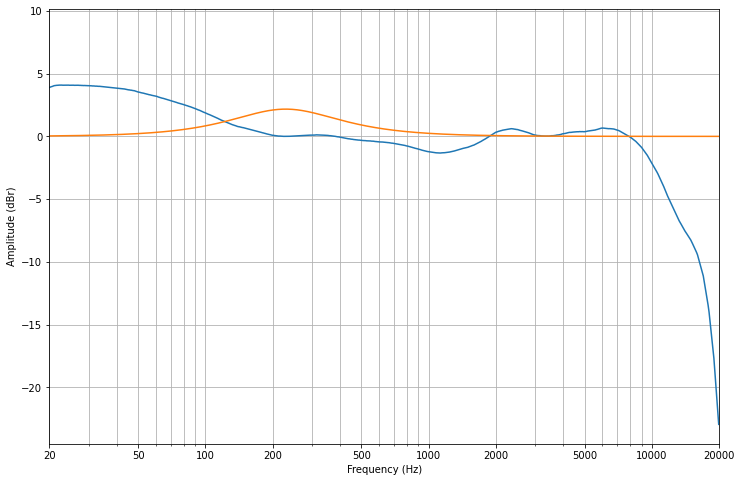

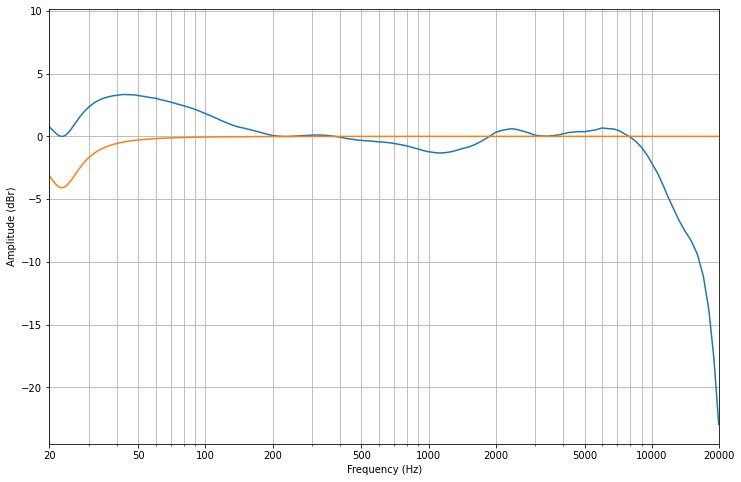

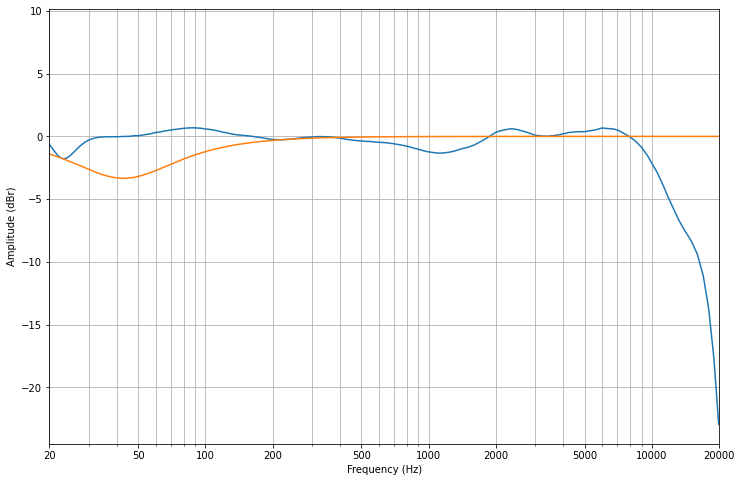

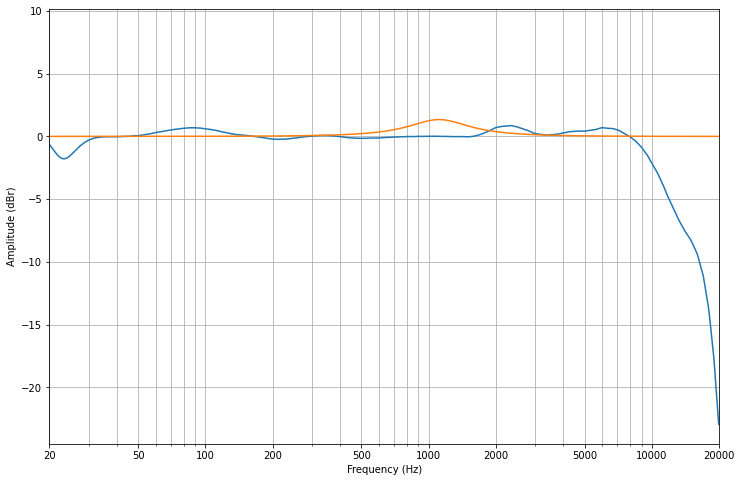

In [68]:
remainder = FrequencyResponse.read_from_csv('../../compensation/harman_over-ear_2018.csv').raw
#remainder = fr.copy()
fig, ax = FrequencyResponse.init_plot()
ax.plot(f, remainder)
ylim = ax.get_ylim()
for _ in range(5):
    ixs, widths, heights = biggest_peaks(remainder)
    ix = ixs[0]
    width = widths[0]
    height = heights[0]
    if remainder[ix] < 0:
        height *= -1
    bw = np.log2((2**f_step)**width)
    q = np.sqrt(2**bw) / (2**bw - 1)
    fig, ax = FrequencyResponse.init_plot()
    filter_fr = digital_coeffs(f, 44100, *peaking(f[ix], q, -height, fs=44100))
    remainder += filter_fr
    ax.plot(f, remainder)
    ax.plot(f, filter_fr)
    ax.set_ylim(ylim)
plt.show()

## Testing Init
Testing the final implementat

In [14]:
from peq import PEQ, HighShelf, LowShelf, Peaking

Init duration: 1 ms


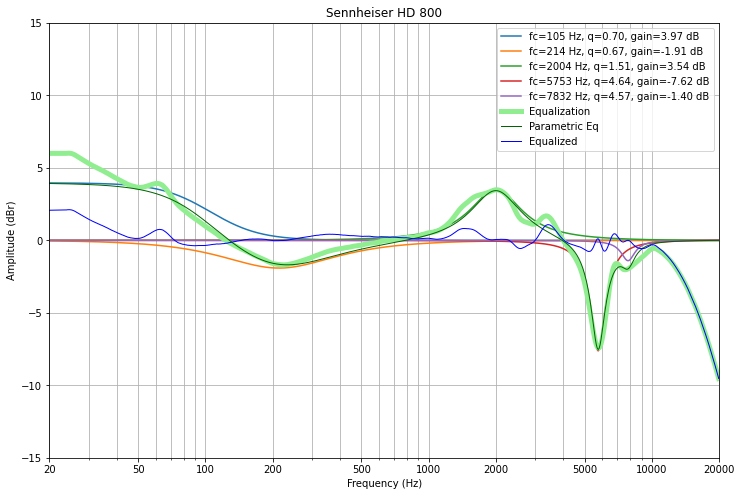

In [132]:
f = FrequencyResponse.generate_frequencies()
fs = 44.1e3
target = FrequencyResponse.read_from_csv('../../results/oratory1990/harman_over-ear_2018/Sennheiser HD 800/Sennheiser HD 800.csv')
peq = PEQ(f, fs, filters=[
    LowShelf(f, fs, optimize_fc=False, fc=105, min_fc=20, max_fc=20e3, optimize_q=False, q=0.7, min_q=0.18, max_q=6, optimize_gain=True, min_gain=-12, max_gain=12),
    Peaking(f, fs, optimize_fc=True, min_fc=20, max_fc=20e3, optimize_q=True, min_q=0.18, max_q=6, optimize_gain=True, min_gain=-12, max_gain=12),
    Peaking(f, fs, optimize_fc=True, min_fc=20, max_fc=20e3, optimize_q=True, min_q=0.18, max_q=6, optimize_gain=True, min_gain=-12, max_gain=12),
    Peaking(f, fs, optimize_fc=True, min_fc=20, max_fc=20e3, optimize_q=True, min_q=0.18, max_q=6, optimize_gain=True, min_gain=-12, max_gain=12),
    Peaking(f, fs, optimize_fc=True, min_fc=20, max_fc=20e3, optimize_q=True, min_q=0.18, max_q=6, optimize_gain=True, min_gain=-12, max_gain=12),
], target=target.equalization)

fig, ax = FrequencyResponse.init_plot()
start_time = time()
params = peq._init_optimizer_params()
print(f'Init duration: {(time() - start_time) * 1000:.0f} ms')
#peq._parse_optimizer_params(params)
for filt in peq.filters:
    ax.plot(filt.f, filt.fr, label=f'fc={filt.fc:.0f} Hz, q={filt.q:.2f}, gain={filt.gain:.2f} dB')
target.parametric_eq = peq.fr
target.equalized_raw = target.equalization - target.parametric_eq
target.plot_graph(fig=fig, ax=ax, raw=False, smoothed=False, error=False, error_smoothed=False, target=False, equalized=True, parametric_eq=True, fixed_band_eq=False, show=False)
ax.legend()
ax.set_ylim([-15, 15])

#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()